### Building trajectories
based on ideas from [here](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9)

In [88]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from data_access.loader import load_processed_data
import logging 

In [89]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [90]:
FOLDER_NAME = '2'
file_name = r'tracking.prqt'
root = r'D:\Users\avitu\Downloads\parquets'
_path = Path(root)/ FOLDER_NAME/ file_name
path = str(_path)
path

'D:\\Users\\avitu\\Downloads\\parquets\\2\\tracking.prqt'

In [91]:
logging.basicConfig(format='%(asctime)s [%(name)s] [%(levelname)s] %(message)s')

In [92]:
df_raw = load_processed_data(path)

In [93]:
df = df_raw.copy()

In [94]:
df.tail()
# df.describe()

,id,frame,x,y,w,h,label,x_prev,y_prev,angle,angle_prev,angle_diff,distance,cum_distance
20401,357,9668,347,235,37,19,car,349.0,235.0,180.000000,161.565051,18.434949,2.000000,208.980230
20402,357,9669,340,228,37,19,car,347.0,235.0,225.000000,180.000000,45.000000,9.899495,218.879725
20404,357,9671,304,242,37,19,car,316.0,240.0,170.537678,153.434949,17.102729,12.165525,257.878066
20405,357,9672,302,243,37,19,car,304.0,242.0,153.434949,170.537678,17.102729,2.236068,260.114134
20406,357,9673,300,242,37,19,car,302.0,243.0,206.565051,153.434949,53.130102,2.236068,262.350202


#### Build dummy data

In [95]:
df.groupby('id').agg({'frame':'count'}).sort_values('frame').tail(5)

,frame
id,
206,299
268,300
59,300
283,372
270,449


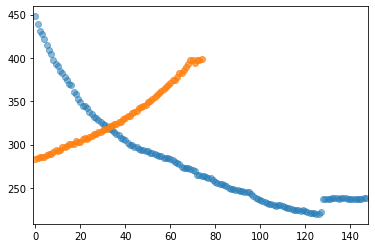

148 148 75


,frame_1,id_1,x_1,y_1,angle_diff_1,angle_1,frame_2,id_2,x_2,y_2,angle_diff_2,angle_2
138,8918,285,138,238,180.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN
139,8919,285,139,237,135.0,315.0,NaN,NaN,NaN,NaN,NaN,NaN
140,8920,285,140,237,45.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
141,8921,285,141,237,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
142,8922,285,142,237,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
143,8923,285,143,237,180.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN
144,8924,285,144,237,180.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
145,8925,285,145,237,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
146,8926,285,146,238,45.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN
147,8927,285,147,238,45.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
from dtw import dtw,accelerated_dtw
cols = ['frame', 'id', 'x','y','angle_diff','angle']
drive_id = 285#225 #160 
drive_id_2 = 91#331
# ddd = df[df.id.isin(ids)][cols].set_index('frame').sort_index()

# -----------------------
ddd = df[cols].set_index('frame').copy()
df_1 = ddd[ddd.id == drive_id].reset_index().copy()
df_2 = ddd[ddd.id == drive_id_2].reset_index().copy() if drive_id_2 else df_1.iloc[80:180,:].reset_index().copy()
df_1['x'] = df_1.index.values
df_2['x'] = df_2.index.values


plt.plot(df_1.x,df_1.y,'o', alpha=0.5)
plt.plot(df_2.x,df_2.y,'o', alpha=0.7)

plt.xlim([min(df_1.x.min(), df_2.x.min())-1, max(df_1.x.max(), df_2.x.max())+ 1 ])
plt.show()

ddd = df_1.join(df_2, lsuffix='_1', rsuffix='_2', how='outer')
print(len(ddd), len(df_1), len(df_2))
ddd.tail(10)

____
##  Time Lagged Cross Correlation — assessing signal dynamics

In [97]:
pd.Series.corr?

Signature: pd.Series.corr(self, other, method='pearson', min_periods=None)
Docstring:
Compute correlation with `other` Series, excluding missing values.

Parameters
----------
other : Series
    Series with which to compute the correlation.
method : {'pearson', 'kendall', 'spearman'} or callable
    * pearson : standard correlation coefficient
    * kendall : Kendall Tau correlation coefficient
    * spearman : Spearman rank correlation
    * callable: callable with input two 1d ndarrays
        and returning a float. Note that the returned matrix from corr
        will have 1 along the diagonals and will be symmetric
        regardless of the callable's behavior
        .. versionadded:: 0.24.0

min_periods : int, optional
    Minimum number of observations needed to have a valid result.

Returns
-------
float
    Correlation with other.

Examples
--------
>>> def histogram_intersection(a, b):
...     v = np.minimum(a, b).sum().round(decimals=1)
...     return v
>>> s1 = pd.Series([.2

In [98]:
method =['pearson', 'kendall', 'spearman',][0]
ddd = ddd.interpolate().ffill().bfill()
is_d1_longer = len(df_1) >= len(df_2)
d1 = df_1.y if is_d1_longer else df_2.y  #ddd[[col for col in ddd.columns if col.endswith('_1')]]
d2 = df_2.y if is_d1_longer else df_1.y

d2 = d2.dropna()
d1 = d1.dropna()

length_diff = len(d1) - len(d2)
d2 = pd.concat([d2, pd.Series([np.nan]* length_diff)])

min_periods=10

(148, 148, 148, 139)


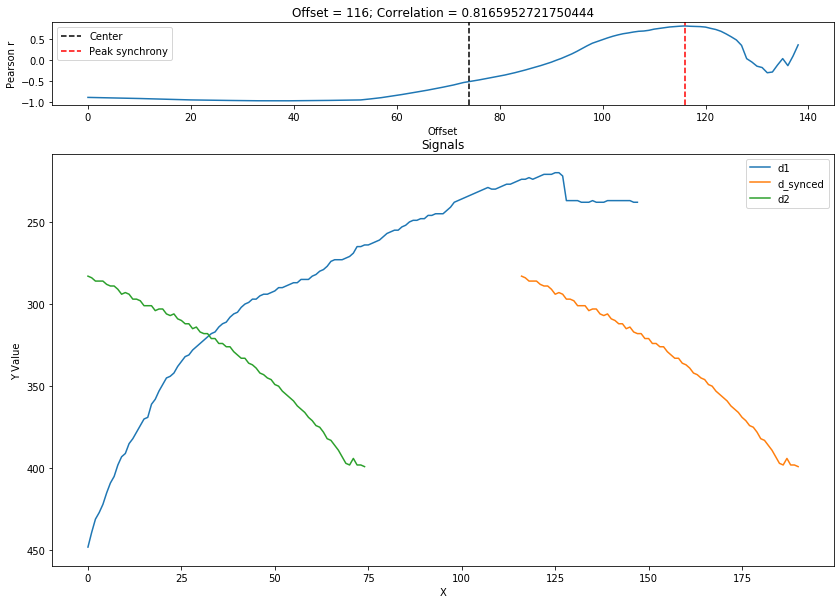

In [99]:
rs = pd.Series([d1.corr(pd.concat([pd.Series([np.nan]* (lag)), d2]).reset_index(drop=True), method=method, min_periods=min_periods) for lag in range(len(d1))])
offset = rs.idxmax() 
best_correlation = rs[offset]

f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,10), gridspec_kw={'height_ratios': [1,5]})
ax_corr, ax_signals = axs

d_synced = pd.concat([pd.Series([np.nan]* (offset)), d2]).reset_index(drop=True)
#  ---- Plot ----
xlim, ylim =[0, len(d1)], None
ax_corr.plot(rs)
ax_corr.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax_corr.axvline(offset,color='r',linestyle='--',label='Peak synchrony')
ax_corr.set(title=f'Offset = {offset}; Correlation = {best_correlation}',ylim=ylim,xlim=ylim, xlabel='Offset',ylabel='Pearson r')
legend = ax_corr.legend()

ax_signals.invert_yaxis()
ax_signals.plot(d1, label='d1')
ax_signals.plot(d_synced, label='d_synced')
ax_signals.plot(d2, label='d2')
ax_signals.set(title=f'Signals',ylim=ylim, xlim=ylim, xlabel='X',ylabel='Y Value')
legend = ax_signals.legend()

print((len(d1), len(d2), len(rs), len(rs.dropna())))

---
### Experimental correlation

In [100]:
# experimental
%matplotlib inline
ddd[['x_1','x_2']].corr()
ddd[['x_1','x_2']].corr()
method =['pearson', 'kendall', 'spearman'][0]
# df_cor = df_cor[[col for col in df_cor.columns if col.endswith('_1')]]

df_cor = ddd.corr(method=method)
# check correlation only for drive 2 va drive 1, and drop non interesting (ids etc)
df_cor = df_cor.loc[[idx for idx in df_cor.index if idx.endswith('_2')], [col for col in df_cor.columns if col.endswith('_1')]]
df_cor = df_cor.dropna(how='all',axis=0).dropna(how='all',axis=1)

# sns.heatmap(df_cor, annot=True)
df_cor
# ddd.x_1.corr(ddd.x_2)

,frame_1,x_1,y_1,angle_diff_1,angle_1
frame_2,0.894425,0.896218,-0.971596,0.358519,-0.378460
x_2,0.894425,0.896218,-0.971596,0.358519,-0.378460
y_2,0.903224,0.904968,-0.951672,0.350257,-0.379640
angle_diff_2,0.259356,0.259305,-0.166882,0.031513,-0.017659
angle_2,-0.456933,-0.457420,0.419201,-0.209722,0.156288


___
##  Dynamic Time Warping 

In [101]:
accelerated_dtw?

Signature: accelerated_dtw(x, y, dist, warp=1)
Docstring:
Computes Dynamic Time Warping (DTW) of two sequences in a faster way.
Instead of iterating through each element and calculating each distance,
this uses the cdist function from scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)

:param array x: N1*M array
:param array y: N2*M array
:param string or func dist: distance parameter for cdist. When string is given, cdist uses optimized functions for the distance metrics.
If a string is passed, the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
:param int warp: how many shifts are computed.
Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap pa

NameError: name 'ids' is not defined

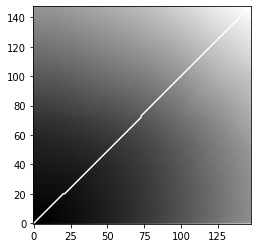

In [102]:
ddd_int = ddd.interpolate().ffill().bfill()
# d1 = df['S1_Joy'].interpolate().values
# d2 = df['S2_Joy'].interpolate().values
# print(len(d1),len(d2))
d1 = ddd_int[[col for col in ddd_int.columns if col.endswith('_1')]].values
d2 = ddd_int[[col for col in ddd_int
              .columns if col.endswith('_2')]].values

d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='correlation')#euclidean

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel(f'Subject1 (len {len(df[df.id==ids[0]])})')
plt.ylabel(f'Subject2 (len {len(df[df.id==ids[1]])})')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')

plt.show()

In [ ]:
pd.DataFrame(list(zip(*path)))
pd.DataFrame(cost_matrix)
pd.DataFrame(acc_cost_matrix)
d